In [ ]:
!pip install yfinance
!pip install clean
!pip install -q praw
!pip install -q asyncpraw
!pip install ffn
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.4/189.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.5/196.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import requests
import tweepy
from pathlib import Path
import clean
import warnings

import praw #reddit data api
import asyncpraw
import ffn
import re #regex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #VADER sentiment model
import json
import csv
import time

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

%matplotlib inline
pd.set_option('display.max_rows', 300)

In [ ]:
#Twitter API
consumer_key    = 'PjwX6vanPHpnxoUtbSgMzRgRi'
consumer_secret = '73JxkiEI9bK3OmqRncjwwhuUVdY50bUG3WBAXIBZyqg91PMYbE'

access_token  = '1533324119080546304-T0gud2D5jqUfiTRxDODoomj8YtAwJN'
access_token_secret = 'dedGpyOQtUNMRo1z04XQ9UPNErz8OMJUDYQdPeW74xhju'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [ ]:
pd.set_option('display.max_colwidth', -1)


warnings.filterwarnings('ignore')
np.random.seed(37)


# nikeTweetPath = Path(__file__).absolute().parent.joinpath('../dataset/5000-justdoit-tweets-dataset/justdoit_tweets_2018_09_07_2.csv')
# tweet_data = pd.read_csv(nikeTweetPath)


# tweet_data = tweet_data[['tweet_created_at','tweet_full_text']]
# tweet_data = tweet_data.dropna()
# tweet_data = tweet_data.reindex(np.random.permutation(tweet_data.index))
# #training_data['sentiment'] = training_data['sentiment'].map({'negative': -1, 'positive': 1,'neutral':.5})
# ct = clean.CleanText()
# sr_clean = ct.fit_transform(tweet_data.tweet_full_text)
# tweet_data['text_clean'] = sr_clean

# tweet_data.to_csv(Path(__file__).absolute().parent.joinpath('../dataset/nike-preprocessed.csv'))


# fetch_tweets=tweepy.Cursor(api.search, q="#NIKE",count=100, lang ="en",since="2018-9-13", tweet_mode="extended").items()
# data=pd.DataFrame(data=[[tweet_info.created_at.date(),tweet_info.full_text]for tweet_info in fetch_tweets],columns=['Date','Tweets'])

In [ ]:
def filtering_date_function(pair):
    key, value = pair
    if key < '2011-01-01' or key > '2023-05-14':
        return False  # filter pair out of the dictionary
    else:
        return True  # keep pair in the filtered dictionary

In [ ]:
#Get Nike stock data
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NKE&interval=60min&apikey=CZS7XN9EGAHLU74N&outputsize=full'
r = requests.get(url)
print(f"Status code: {r.status_code}")
nike_stock_over_time = r.json()

#filter by date
filtered_nike_stocks = dict(filter(filtering_date_function, nike_stock_over_time['Time Series (Daily)'].items()))

#parse data
nike_close = [float(val["5. adjusted close"]) for val in filtered_nike_stocks.values()][::-1]
nike_days_chronological = [key for key in filtered_nike_stocks.keys()][::-1]
print("There are", len(nike_close), "days represented for Nike stock")

Status code: 200
There are 3111 days represented for Nike stock


In [ ]:
#Get Adidas stock data/Screen Shot 2023-05-17 at 3.49.26 PM.png
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=ADDYY&interval=60min&apikey=CZS7XN9EGAHLU74N&outputsize=full'
r = requests.get(url)
print(f"Status code: {r.status_code}")
adidas_stock_over_time = r.json()

#filter by date
filtered_adidas_stocks = dict(filter(filtering_date_function, adidas_stock_over_time['Time Series (Daily)'].items()))

#parse data
adidas_close = [float(val["5. adjusted close"]) for val in filtered_adidas_stocks.values()][::-1]
adidas_days_chronological = [key for key in filtered_adidas_stocks.keys()][::-1]
print("There are", len(adidas_close), "days represented for Adidas stock")

Status code: 200
There are 3111 days represented for Adidas stock


In [ ]:
#Get Under Armour stock data
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=UAA&interval=60min&apikey=CZS7XN9EGAHLU74N&outputsize=full'
r = requests.get(url)
print(f"Status code: {r.status_code}")
ua_stock_over_time = r.json()

#filter by date
filtered_ua_stocks = dict(filter(filtering_date_function, ua_stock_over_time['Time Series (Daily)'].items()))

#parse data
ua_close = [float(val["5. adjusted close"]) for val in filtered_ua_stocks.values()][::-1]
ua_days_chronological = [key for key in filtered_ua_stocks.keys()][::-1]
print("There are", len(ua_close), "days represented for Under Armour stock")


Status code: 200
There are 3111 days represented for Under Armour stock


In [ ]:
#Get Sketchers stock data
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=SKX&interval=60min&apikey=CZS7XN9EGAHLU74N&outputsize=full'
r = requests.get(url)
print(f"Status code: {r.status_code}")
sk_stock_over_time = r.json()

#filter by date
filtered_sk_stocks = dict(filter(filtering_date_function, sk_stock_over_time['Time Series (Daily)'].items()))

#parse data
sk_close = [float(val["5. adjusted close"]) for val in filtered_sk_stocks.values()][::-1]
sk_days_chronological = [key for key in filtered_sk_stocks.keys()][::-1]
print("There are", len(sk_close), "days represented for Sketchers stock")


Status code: 200
There are 3111 days represented for Sketchers stock


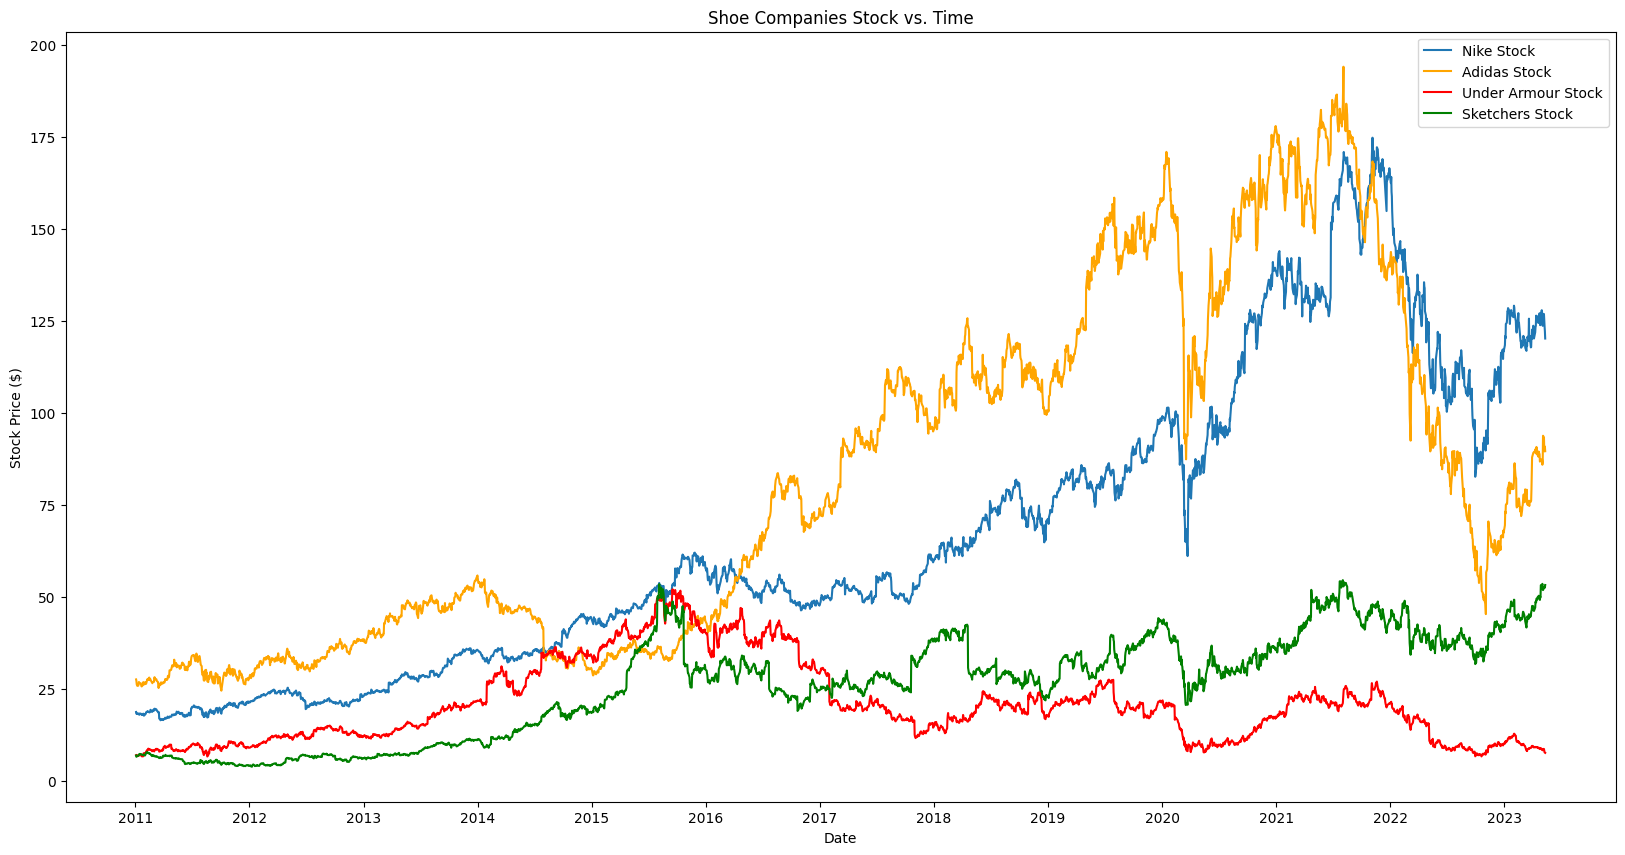

In [ ]:
#Graph Stock Data over past 20 years
plt.figure(figsize = (20, 10))
nike_dates = [mdates.datestr2num(date) for date in nike_days_chronological]
plt.plot(nike_dates, nike_close, label = 'Nike Stock')

adidas_dates = [mdates.datestr2num(date) for date in adidas_days_chronological]
plt.plot(adidas_dates, adidas_close, label = 'Adidas Stock', color="orange")

ua_dates = [mdates.datestr2num(date) for date in ua_days_chronological]
plt.plot(ua_dates, ua_close, label = 'Under Armour Stock', color="red")

sk_dates = [mdates.datestr2num(date) for date in sk_days_chronological]
plt.plot(sk_dates, sk_close, label = 'Sketchers Stock', color="green")

plt.xlabel('Date')
plt.title("Shoe Companies Stock vs. Time")
plt.ylabel('Stock Price ($)')
plt.legend()

# Set the x-axis tick locator to years
nike_years = mdates.YearLocator()
plt.gca().xaxis.set_major_locator(nike_years)

# Set the format of the year labels
year_format = mdates.DateFormatter('%Y')
plt.gca().xaxis.set_major_formatter(year_format)

plt.show()

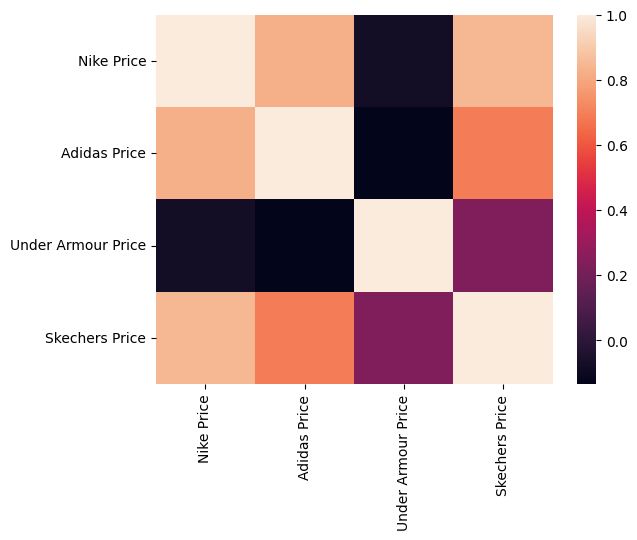

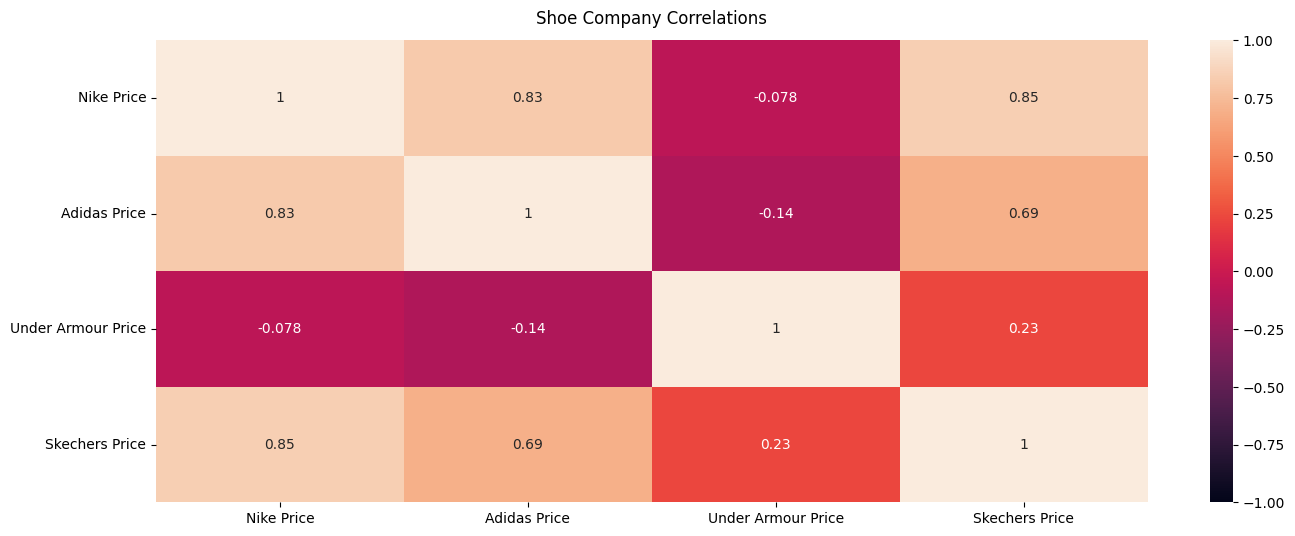

In [ ]:
feature_df = pd.DataFrame({"Days":nike_days_chronological, "Nike Price":nike_close, "Adidas Price": adidas_close, "Under Armour Price": ua_close, "Skechers Price": sk_close})
joe = sns.heatmap(feature_df.corr());
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(feature_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Shoe Company Correlations', fontdict={'fontsize':12}, pad=12);

In [ ]:

feature_df["Nike ma7"] = feature_df["Nike Price"].rolling(window=7).mean()
feature_df["Nike ma21"] = feature_df["Nike Price"].rolling(window=21).mean()
feature_df["Adidas ma7"] = feature_df["Adidas Price"].rolling(window=7).mean()
feature_df["Adidas ma21"] = feature_df["Adidas Price"].rolling(window=21).mean()
feature_df["Skechers ma7"] = feature_df["Skechers Price"].rolling(window=7).mean()
feature_df["Skechers ma21"] = feature_df["Skechers Price"].rolling(window=21).mean()

feature_df['Nike 26ema'] = feature_df['Nike Price'].ewm(span=26).mean()
feature_df['Nike 12ema'] = feature_df['Nike Price'].ewm(span=12).mean()
feature_df['Nike MACD'] = feature_df['Nike 12ema']-feature_df['Nike 26ema']

feature_df['Adidas 26ema'] = feature_df['Adidas Price'].ewm(span=26).mean()
feature_df['Adidas 12ema'] = feature_df['Adidas Price'].ewm(span=12).mean()
feature_df['Adidas MACD'] = feature_df['Adidas 12ema']-feature_df['Adidas 26ema']

feature_df['Skechers 26ema'] = feature_df['Skechers Price'].ewm(span=26).mean()
feature_df['Skechers 12ema'] = feature_df['Skechers Price'].ewm(span=12).mean()
feature_df['Skechers MACD'] = feature_df['Skechers 12ema']-feature_df['Skechers 26ema']

feature_df['Nike 20sd'] = feature_df['Nike Price'].rolling(window = 21).std()
feature_df['Nike upperband'] = feature_df['Nike ma21'] + (feature_df['Nike 20sd']*2)
feature_df['Nike lowerband'] = feature_df['Nike ma21'] - (feature_df['Nike 20sd']*2)

feature_df['Nike ema'] = feature_df['Nike Price'].ewm(com=0.5).mean()

feature_df['Nike momentum'] = feature_df['Nike Price']-1
feature_df['Nike log_momentum'] = np.log(feature_df['Nike momentum'])

In [ ]:
#Get feature set
feature_df

,Days,Nike Price,Adidas Price,Under Armour Price,Skechers Price,Nike ma7,Nike ma21,Adidas ma7,Adidas ma21,Skechers ma7,...,Adidas MACD,Skechers 26ema,Skechers 12ema,Skechers MACD,Nike 20sd,Nike upperband,Nike lowerband,Nike ema,Nike momentum,Nike log_momentum
0,2011-01-03,18.698735,27.551713,6.94625,6.856660,NaN,NaN,NaN,NaN,NaN,...,0.000000,6.856660,6.856660,0.000000,NaN,NaN,NaN,18.698735,17.698735,2.873493
1,2011-01-04,18.238272,27.097979,6.83125,6.519993,NaN,NaN,NaN,NaN,NaN,...,-0.010180,6.681852,6.674299,-0.007553,NaN,NaN,NaN,18.353388,17.238272,2.847132
2,2011-01-05,18.357732,26.215719,6.94250,6.636660,NaN,NaN,NaN,NaN,NaN,...,-0.040330,6.665615,6.659608,-0.006007,NaN,NaN,NaN,18.356395,17.357732,2.854038
3,2011-01-06,18.192660,25.946840,6.83000,6.679993,NaN,NaN,NaN,NaN,NaN,...,-0.062762,6.669635,6.666043,-0.003592,NaN,NaN,NaN,18.245874,17.192660,2.844483
4,2011-01-07,18.142704,25.795596,6.69375,6.729993,NaN,NaN,NaN,NaN,NaN,...,-0.079649,6.683632,6.683418,-0.000214,NaN,NaN,NaN,18.176810,17.142704,2.841573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,2023-05-08,126.880000,93.323312,8.65000,52.410000,126.540000,125.541429,88.802058,88.797559,52.727143,...,1.775342,50.019478,51.574641,1.555163,1.560581,128.662590,122.420267,126.579405,125.880000,4.835329
3107,2023-05-09,125.100000,90.251534,8.16000,52.710000,126.308571,125.693333,89.217413,88.827904,52.658571,...,1.741821,50.218776,51.749312,1.530536,1.327239,128.347811,123.038855,125.593135,124.100000,4.821088
3108,2023-05-10,123.510000,89.584405,7.71000,52.570000,125.678571,125.703333,89.545999,88.800878,52.577143,...,1.642490,50.392941,51.875572,1.482631,1.308970,128.321274,123.085393,124.204378,122.510000,4.808193
3109,2023-05-11,122.220000,90.848962,7.65000,52.500000,124.958571,125.634762,90.049546,88.889069,52.504286,...,1.646826,50.549019,51.971637,1.422618,1.451339,128.537441,122.732083,122.881459,121.220000,4.797607


In [ ]:
# Get rid of all NaN Data points
feature_df = feature_df.dropna()
feature_df.head()

,Days,Nike Price,Adidas Price,Under Armour Price,Skechers Price,Nike ma7,Nike ma21,Adidas ma7,Adidas ma21,Skechers ma7,...,Adidas MACD,Skechers 26ema,Skechers 12ema,Skechers MACD,Nike 20sd,Nike upperband,Nike lowerband,Nike ema,Nike momentum,Nike log_momentum
20,2011-02-01,18.147048,26.795490,7.52250,6.999993,17.990354,18.134223,26.405375,26.356161,7.015707,...,0.023393,7.008205,7.019242,0.011038,0.212025,18.558273,17.710172,18.057731,17.147048,2.841826
21,2011-02-02,18.225240,26.719868,7.42625,7.113326,18.029139,18.111675,26.513407,26.316549,7.024279,...,0.045142,7.017747,7.034093,0.016346,0.170004,18.451683,17.771667,18.169403,17.225240,2.846376
22,2011-02-03,18.201348,26.568623,7.53250,7.376659,18.057686,18.109917,26.555419,26.291341,7.070945,...,0.051199,7.049790,7.087951,0.038160,0.168816,18.447549,17.772285,18.190700,17.201348,2.844988
23,2011-02-04,18.622715,26.358561,7.96250,7.603326,18.111675,18.122535,26.488199,26.298143,7.155707,...,0.040858,7.098470,7.168704,0.070235,0.195983,18.514500,17.730570,18.478710,17.622715,2.869189
24,2011-02-07,18.787787,27.266028,8.18875,7.803326,18.227412,18.150875,26.595031,26.360962,7.250469,...,0.095410,7.159609,7.267861,0.108252,0.243820,18.638514,17.663235,18.684762,17.787787,2.878512


In [ ]:
print(len(feature_df.columns))
feature_df.columns

26


Index(['Days', 'Nike Price', 'Adidas Price', 'Under Armour Price',
       'Skechers Price', 'Nike ma7', 'Nike ma21', 'Adidas ma7', 'Adidas ma21',
       'Skechers ma7', 'Skechers ma21', 'Nike 26ema', 'Nike 12ema',
       'Nike MACD', 'Adidas 26ema', 'Adidas 12ema', 'Adidas MACD',
       'Skechers 26ema', 'Skechers 12ema', 'Skechers MACD', 'Nike 20sd',
       'Nike upperband', 'Nike lowerband', 'Nike ema', 'Nike momentum',
       'Nike log_momentum'],
      dtype='object')

In [ ]:
training = feature_df[feature_df['Days'] < '2019-01-31'].copy()
del training['Days']
training

,Nike Price,Adidas Price,Under Armour Price,Skechers Price,Nike ma7,Nike ma21,Adidas ma7,Adidas ma21,Skechers ma7,Skechers ma21,...,Adidas MACD,Skechers 26ema,Skechers 12ema,Skechers MACD,Nike 20sd,Nike upperband,Nike lowerband,Nike ema,Nike momentum,Nike log_momentum
20,18.147048,26.795490,7.52250,6.999993,17.990354,18.134223,26.405375,26.356161,7.015707,6.971104,...,0.023393,7.008205,7.019242,0.011038,0.212025,18.558273,17.710172,18.057731,17.147048,2.841826
21,18.225240,26.719868,7.42625,7.113326,18.029139,18.111675,26.513407,26.316549,7.024279,6.983326,...,0.045142,7.017747,7.034093,0.016346,0.170004,18.451683,17.771667,18.169403,17.225240,2.846376
22,18.201348,26.568623,7.53250,7.376659,18.057686,18.109917,26.555419,26.291341,7.070945,7.024120,...,0.051199,7.049790,7.087951,0.038160,0.168816,18.447549,17.772285,18.190700,17.201348,2.844988
23,18.622715,26.358561,7.96250,7.603326,18.111675,18.122535,26.488199,26.298143,7.155707,7.070152,...,0.040858,7.098470,7.168704,0.070235,0.195983,18.514500,17.730570,18.478710,17.622715,2.869189
24,18.787787,27.266028,8.18875,7.803326,18.227412,18.150875,26.595031,26.360962,7.250469,7.123644,...,0.095410,7.159609,7.267861,0.108252,0.243820,18.638514,17.663235,18.684762,17.787787,2.878512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,77.206872,109.857786,20.74000,26.010000,76.349901,73.043138,110.644338,106.000068,25.905714,24.449524,...,1.729135,24.977955,25.402725,0.424770,3.056895,79.156928,66.929348,77.220186,76.206872,4.333452
2028,77.370039,111.846814,21.44000,26.630000,76.724226,73.614909,110.988883,106.567905,26.111429,24.676667,...,1.806052,25.100329,25.591537,0.491208,2.643502,78.901913,68.327904,77.320088,76.370039,4.335590
2029,77.091695,111.760335,21.34000,26.910000,77.086210,73.949013,111.440498,107.094103,26.334286,24.849524,...,1.838833,25.234379,25.794377,0.559999,2.617046,79.183105,68.714920,77.167826,76.091695,4.331939
2030,76.995714,112.038991,20.89000,26.610000,77.235666,74.248381,111.753471,107.693511,26.285714,25.015238,...,1.865790,25.336277,25.919858,0.583581,2.587288,79.422957,69.073806,77.053085,75.995714,4.330677


In [ ]:
testing = feature_df[feature_df['Days'] >= '2019-01-31'].copy()
del testing['Days']
testing

,Nike Price,Adidas Price,Under Armour Price,Skechers Price,Nike ma7,Nike ma21,Adidas ma7,Adidas ma21,Skechers ma7,Skechers ma21,...,Adidas MACD,Skechers 26ema,Skechers 12ema,Skechers MACD,Nike 20sd,Nike upperband,Nike lowerband,Nike ema,Nike momentum,Nike log_momentum
2032,78.588994,114.364329,20.74,27.17,77.504412,74.965037,112.443935,109.011294,26.598571,25.415714,...,2.140441,25.606108,26.290549,0.684441,2.566149,80.097334,69.832740,78.290363,77.588994,4.351426
2033,78.233865,109.828959,20.63,26.89,77.642899,75.305540,111.933294,109.441861,26.787143,25.591905,...,1.857245,25.701211,26.382772,0.681561,2.498849,80.303239,70.307841,78.252698,77.233865,4.346838
2034,78.694573,108.272329,20.70,27.20,77.855427,75.727855,111.706800,109.814775,26.957143,25.816190,...,1.490026,25.812233,26.508500,0.696267,2.264943,80.257741,71.197969,78.547281,77.694573,4.352785
2035,79.529605,111.145370,20.90,27.58,78.163937,76.103094,111.606594,110.130036,27.092857,26.030000,...,1.414527,25.943178,26.673346,0.730167,2.207527,80.518148,71.688040,79.202164,78.529605,4.363476
2036,79.385634,110.280575,20.72,27.67,78.491642,76.422573,111.395199,110.389475,27.201429,26.192857,...,1.270269,26.071091,26.826677,0.755586,2.172029,80.766630,72.078515,79.324477,78.385634,4.361641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,126.880000,93.323312,8.65,52.41,126.540000,125.541429,88.802058,88.797559,52.727143,50.472381,...,1.775342,50.019478,51.574641,1.555163,1.560581,128.662590,122.420267,126.579405,125.880000,4.835329
3107,125.100000,90.251534,8.16,52.71,126.308571,125.693333,89.217413,88.827904,52.658571,50.740476,...,1.741821,50.218776,51.749312,1.530536,1.327239,128.347811,123.038855,125.593135,124.100000,4.821088
3108,123.510000,89.584405,7.71,52.57,125.678571,125.703333,89.545999,88.800878,52.577143,50.924762,...,1.642490,50.392941,51.875572,1.482631,1.308970,128.321274,123.085393,124.204378,122.510000,4.808193
3109,122.220000,90.848962,7.65,52.50,124.958571,125.634762,90.049546,88.889069,52.504286,51.115238,...,1.646826,50.549019,51.971637,1.422618,1.451339,128.537441,122.732083,122.881459,121.220000,4.797607


In [ ]:
scalar = MinMaxScaler()

training_scaled = scalar.fit_transform(training)
print(training_scaled.shape)
training_scaled

(2012, 25)


array([[0.02602535, 0.02269628, 0.02035092, ..., 0.02292529, 0.02602535,
        0.06317102],
       [0.02722044, 0.02194935, 0.01823332, ..., 0.02463919, 0.02722044,
        0.06591905],
       [0.02685527, 0.0204555 , 0.02057093, ..., 0.02496604, 0.02685527,
        0.0650807 ],
       ...,
       [0.9269417 , 0.86190055, 0.3243496 , ..., 0.93012436, 0.9269417 ,
        0.96320124],
       [0.92547472, 0.86465286, 0.31444915, ..., 0.92836335, 0.92547472,
        0.96243888],
       [0.94102471, 0.8824005 , 0.31510918, ..., 0.93818608, 0.94102471,
        0.97047132]])

In [ ]:
x = []
y = []
for i in range(60, training.shape[0]):
    x.append(training_scaled[i-60: i])
    y.append(training_scaled[i, 0])

x, y = np.array(x), np.array(y)
y

array([0.02371787, 0.02288508, 0.02261858, ..., 0.9269417 , 0.92547472,
       0.94102471])

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x.shape[1], 25)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [ ]:
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 60, 50)            15200     
                                                                 
 dropout_28 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_29 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_29 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_30 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_30 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_31 (LSTM)              (None, 120)              

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(x, y, epochs=2, batch_size = 64)

Epoch 1/2
31/31 [==============================] - 20s 446ms/step - loss: 0.0524
Epoch 2/2
31/31 [==============================] - 16s 504ms/step - loss: 0.0092


In [ ]:
past_60 = training.tail(60)

dt = past_60.append(testing, ignore_index = True)
dt

,Nike Price,Adidas Price,Under Armour Price,Skechers Price,Nike ma7,Nike ma21,Adidas ma7,Adidas ma21,Skechers ma7,Skechers ma21,...,Adidas MACD,Skechers 26ema,Skechers 12ema,Skechers MACD,Nike 20sd,Nike upperband,Nike lowerband,Nike ema,Nike momentum,Nike log_momentum
0,73.488355,112.125471,23.34,28.87,70.520275,72.419700,111.658756,111.164130,27.402857,26.856190,...,-0.754484,27.305848,27.525467,0.219619,2.578728,77.577157,67.262244,72.793625,72.488355,4.283426
1,73.287384,113.605231,23.70,29.24,71.130023,72.255642,112.316275,111.062093,27.798571,26.991905,...,-0.542603,27.449119,27.789241,0.340123,2.393568,77.042779,67.468506,73.122798,72.287384,4.280650
2,74.196538,113.672493,23.99,30.12,71.735670,72.137612,112.386282,111.003067,28.312857,27.184762,...,-0.365050,27.646962,28.147820,0.500858,2.219522,76.576656,67.698567,73.838625,73.196538,4.293148
3,73.277814,113.393836,23.30,30.15,72.350887,71.970820,112.636111,110.963717,28.822857,27.357143,...,-0.244010,27.832372,28.455847,0.623476,1.970856,75.912532,68.029107,73.464751,72.277814,4.280517
4,74.617620,110.030745,22.88,29.23,73.141099,71.859169,112.404127,110.831023,29.171429,27.484762,...,-0.414678,27.935900,28.574948,0.639048,1.725030,75.309229,68.409109,74.233330,73.617620,4.298884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,126.880000,93.323312,8.65,52.41,126.540000,125.541429,88.802058,88.797559,52.727143,50.472381,...,1.775342,50.019478,51.574641,1.555163,1.560581,128.662590,122.420267,126.579405,125.880000,4.835329
1135,125.100000,90.251534,8.16,52.71,126.308571,125.693333,89.217413,88.827904,52.658571,50.740476,...,1.741821,50.218776,51.749312,1.530536,1.327239,128.347811,123.038855,125.593135,124.100000,4.821088
1136,123.510000,89.584405,7.71,52.57,125.678571,125.703333,89.545999,88.800878,52.577143,50.924762,...,1.642490,50.392941,51.875572,1.482631,1.308970,128.321274,123.085393,124.204378,122.510000,4.808193
1137,122.220000,90.848962,7.65,52.50,124.958571,125.634762,90.049546,88.889069,52.504286,51.115238,...,1.646826,50.549019,51.971637,1.422618,1.451339,128.537441,122.732083,122.881459,121.220000,4.797607


In [ ]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(1139, 25)


array([[0.10907249, 0.44908118, 0.80038296, ..., 0.08982339, 0.10907249,
        0.1766874 ],
       [0.10730529, 0.45902622, 0.81761608, ..., 0.09279499, 0.10730529,
        0.17407366],
       [0.11529977, 0.45947827, 0.83149832, ..., 0.0992571 , 0.11529977,
        0.18584032],
       ...,
       [0.54892879, 0.29758917, 0.05217808, ..., 0.55393249, 0.54892879,
        0.67072662],
       [0.53758541, 0.30608789, 0.04930589, ..., 0.54198987, 0.53758541,
        0.66076087],
       [0.51991083, 0.29762677, 0.0464337 , ..., 0.52591219, 0.51991083,
        0.6450195 ]])

In [ ]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((1079, 60, 25), (1079,))

In [ ]:
y_pred = regressor.predict(X_test)
y_pred

34/34 [==============================] - 2s 34ms/step


array([[0.18067501],
       [0.18172248],
       [0.1829039 ],
       ...,
       [0.5314216 ],
       [0.5337174 ],
       [0.535824  ]], dtype=float32)

In [ ]:
scale = 1/scalar.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale
print(y_pred)
print(y_test)

[[20.54685 ]
 [20.665972]
 [20.800325]
 ...
 [60.4347  ]
 [60.695786]
 [60.935352]]
[17.50465691 17.14952834 17.61023568 ... 62.42566295 61.13566295
 59.12566295]


In [ ]:
r2 = r2_score(y_test, y_pred)
print("The R2 accuracy of our model is {}%".format(round(r2, 2) *100))

mae = mean_absolute_error(y_test, y_pred)
print("The Mean Absolute Error of our Model is {}".format(round(mae, 2)))

The R2 accuracy of our model is 83.0%
The Mean Absolute Error of our Model is 8.95


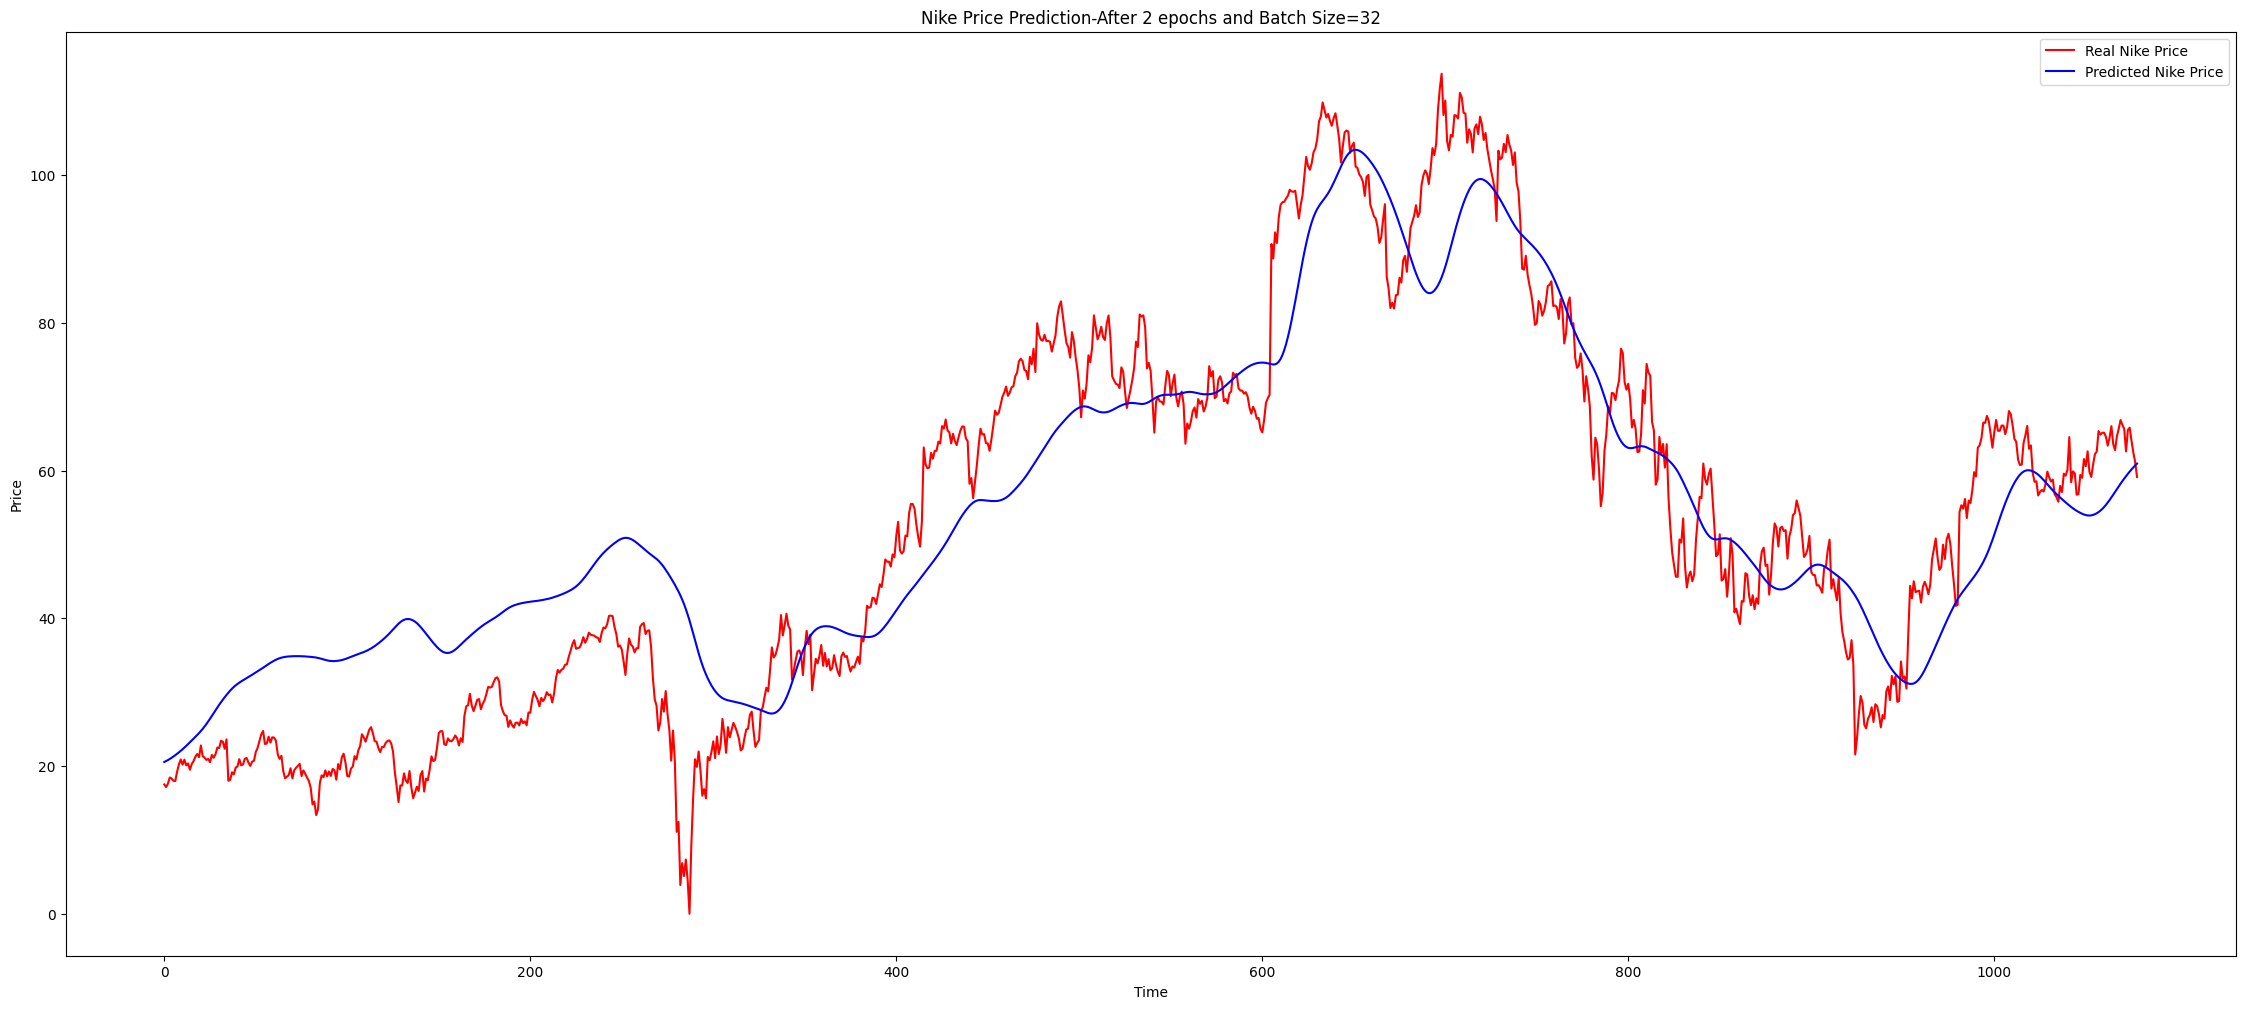

In [ ]:
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Nike Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nike Price')
plt.title('Nike Price Prediction-After 2 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Subreddit to query
sub='stocks'
# Start and end dates 
before = "1673941342" #january 17 2023
after = "1547713704" #january 17 2019
# Query string (i.e. thread we'd like to parse)
query1 = "Nike"
query2 = "NKE"
subCount = 0
subStats = []

In [ ]:
# Pulls subreddit data from r/stocks subreddit between specified dates, using query strings (NIKE or NKE)
def getPushshiftData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    # print(url)
    r = requests.get(url)
    try:
      data = json.loads(r.text)
      return data['data']
    except:
      print("Empty API call")
      return []
    

# Parse the retrieved data to make it interprettable for sentiment analysis
def collectSubData(subm):
    subData = [subm['id'], subm['title'], subm['url'], datetime.datetime.fromtimestamp(subm['created_utc']).date()]
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    subData.append(flair)
    subStats.append(subData)


data = getPushshiftData(query1, after, before, sub)
data += getPushshiftData(query2, after, before, sub)
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    after = data[-1]['created_utc']
    data = getPushshiftData(query1, after, before, sub)
    data = getPushshiftData(query2, after, before, sub)

Empty API call
Empty API call


In [ ]:
# Create dataframe to hold data
data={}
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs
df_1=pd.DataFrame(data)
# df_1=df_1[df_1['flair']=='Nike']

In [ ]:
# Connect to Reddit API using our secret key and web app credentials
reddit = asyncpraw.Reddit(client_id='V00kIJZzUbbg4J89HASw5w', client_secret='kdV12zDMY1cBmpBEMyQi9fhKVTwN0g', user_agent='ai prac')

# Collect and query comments using PRAW
comments_by_day=[]
for url in df_1['url'].tolist():
    try:
        submission = await reddit.submission(url=url)
        await submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments])
    except:
        comments=None
    comments_by_day.append(comments)
await reddit.close()

In [ ]:
analyser = SentimentIntensityAnalyzer()

scores=[]
for comments in comments_by_day:
    sentiment_score=0
    try:
        for comment in comments:
            sentiment_score=sentiment_score+analyser.polarity_scores(comment)['compound']
    except TypeError:
        sentiment_score=0
    
    scores.append(sentiment_score)
  
df_1['sentiment score']=scores

In [ ]:
nike_vals = []
# df_1['date'].tolist()
prev = 0.0
for i, date in enumerate(dates):
    try:
        nike_vals.append(float(filtered_nike_stocks[str(date)]['4. close']))
        prev = nike_vals[-1]
    except KeyError:
        nike_vals.append(prev)
df_1['nike']=nike_vals
df_2=df_1[['date','sentiment score','nike']]
df_3=df_2.set_index('date')
df_4=df_3[df_3['nike'].notna()]

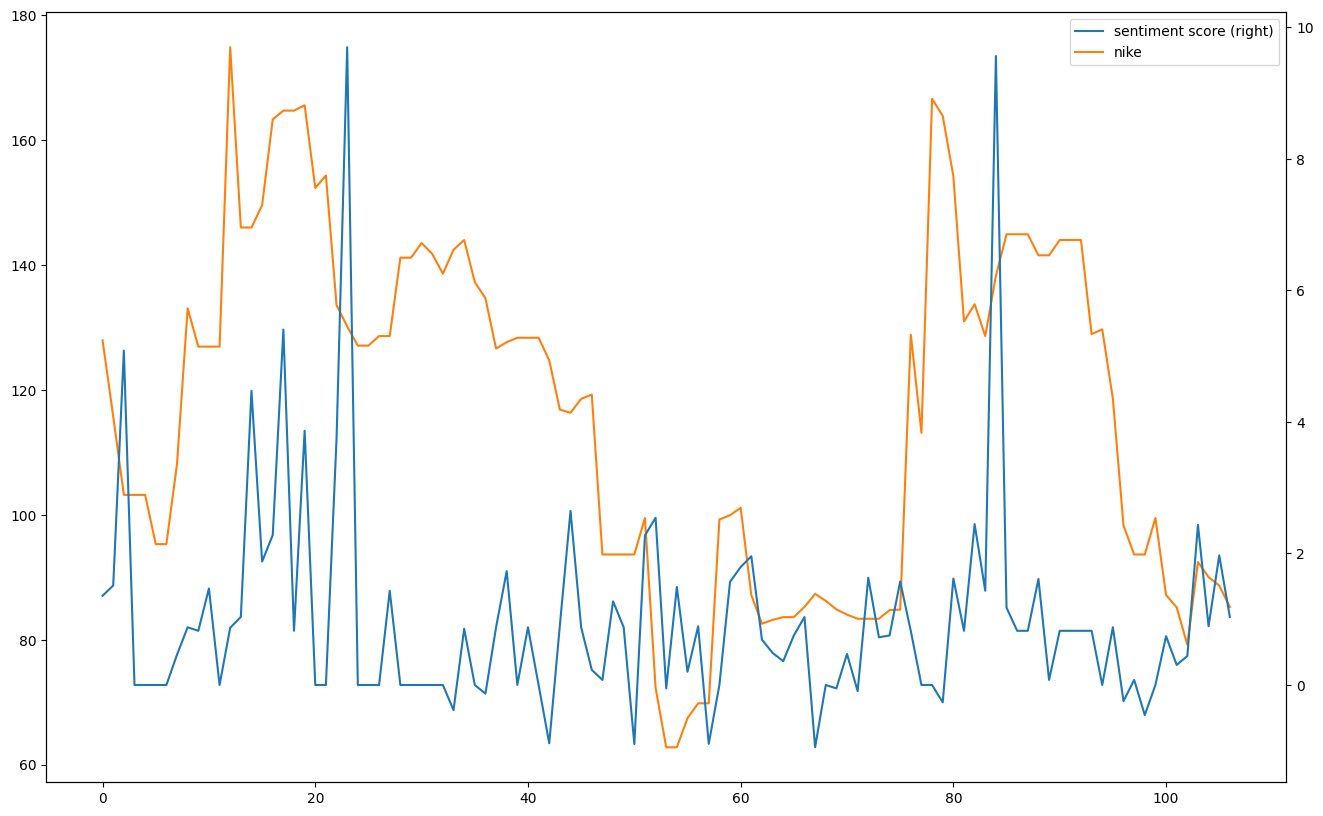

In [ ]:
df_4 = pd.read_csv('output (1).csv')

df_4.plot(secondary_y='sentiment score', figsize=(16, 10))
df_4.to_csv('positive+negative_sentiment_data_1.csv')

plt.show()

In [ ]:
from google.colab import files
df_4.to_csv('output.csv') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def filtering_date_sent_function(pair):
    key, value = pair
    if key < '2019-01-17' or key > '2023-01-17':
        return False  # filter pair out of the dictionary
    else:
        return True  # keep pair in the filtered dictionary

In [ ]:
filtered_nike_stocks = dict(filter(filtering_date_sent_function, nike_stock_over_time['Time Series (Daily)'].items()))
nike_close = [float(val["5. adjusted close"]) for val in filtered_nike_stocks.values()][::-1]
nike_days_chronological = [key for key in filtered_nike_stocks.keys()][::-1]

filtered_adidas_stocks = dict(filter(filtering_date_sent_function, adidas_stock_over_time['Time Series (Daily)'].items()))
adidas_close = [float(val["5. adjusted close"]) for val in filtered_adidas_stocks.values()][::-1]
adidas_days_chronological = [key for key in filtered_adidas_stocks.keys()][::-1]

filtered_sk_stocks = dict(filter(filtering_date_sent_function, sk_stock_over_time['Time Series (Daily)'].items()))
sk_close = [float(val["5. adjusted close"]) for val in filtered_sk_stocks.values()][::-1]
sk_days_chronological = [key for key in filtered_sk_stocks.keys()][::-1]

filtered_ua_stocks = dict(filter(filtering_date_sent_function, ua_stock_over_time['Time Series (Daily)'].items()))
ua_close = [float(val["5. adjusted close"]) for val in filtered_ua_stocks.values()][::-1]
ua_days_chronological = [key for key in filtered_ua_stocks.keys()][::-1]

sentiment = list(pd.read_csv('output.csv')['sentiment score'])
stretched = np.repeat(sentiment, 10)
print(len(nike_close), len(stretched))
feature_df = pd.DataFrame({"Days":nike_days_chronological, "Nike Price":nike_close, "Adidas Price": adidas_close, "Under Armour Price": ua_close, "Skechers Price": sk_close, "Sentiment Score": stretched[:len(nike_close)]})

1007 1070


In [ ]:

feature_df["Nike ma7"] = feature_df["Nike Price"].rolling(window=7).mean()
feature_df["Nike ma21"] = feature_df["Nike Price"].rolling(window=21).mean()
feature_df["Adidas ma7"] = feature_df["Adidas Price"].rolling(window=7).mean()
feature_df["Adidas ma21"] = feature_df["Adidas Price"].rolling(window=21).mean()
feature_df["Skechers ma7"] = feature_df["Skechers Price"].rolling(window=7).mean()
feature_df["Skechers ma21"] = feature_df["Skechers Price"].rolling(window=21).mean()
feature_df["Sentiment ma7"] = feature_df["Sentiment Score"].rolling(window=7).mean()
feature_df["Sentiment ma21"] = feature_df["Sentiment Score"].rolling(window=21).mean()

feature_df['Nike 26ema'] = feature_df['Nike Price'].ewm(span=26).mean()
feature_df['Nike 12ema'] = feature_df['Nike Price'].ewm(span=12).mean()
feature_df['Nike MACD'] = feature_df['Nike 12ema']-feature_df['Nike 26ema']

feature_df['Sentiment 26ema'] = feature_df['Sentiment Score'].ewm(span=26).mean()
feature_df['Sentiment 12ema'] = feature_df['Sentiment Score'].ewm(span=12).mean()
feature_df['Sentiment MACD'] = feature_df['Sentiment 12ema']-feature_df['Sentiment 26ema']

feature_df['Adidas 26ema'] = feature_df['Adidas Price'].ewm(span=26).mean()
feature_df['Adidas 12ema'] = feature_df['Adidas Price'].ewm(span=12).mean()
feature_df['Adidas MACD'] = feature_df['Adidas 12ema']-feature_df['Adidas 26ema']

feature_df['Skechers 26ema'] = feature_df['Skechers Price'].ewm(span=26).mean()
feature_df['Skechers 12ema'] = feature_df['Skechers Price'].ewm(span=12).mean()
feature_df['Skechers MACD'] = feature_df['Skechers 12ema']-feature_df['Skechers 26ema']

feature_df['Nike 20sd'] = feature_df['Nike Price'].rolling(window = 21).std()
feature_df['Nike upper_band'] = feature_df['Nike ma21'] + (feature_df['Nike 20sd']*2)
feature_df['Nike lower_band'] = feature_df['Nike ma21'] - (feature_df['Nike 20sd']*2)

feature_df['Nike ema'] = feature_df['Nike Price'].ewm(com=0.5).mean()

feature_df['Nike momentum'] = feature_df['Nike Price']-1
feature_df['Nike log_momentum'] = np.log(feature_df['Nike momentum'])

In [ ]:
feature_df = feature_df.dropna()
training = feature_df[feature_df['Days'] < '2020-01-31'].copy()
del training['Days']

testing = feature_df[feature_df['Days'] >= '2020-01-31'].copy()
del testing['Days']

scalar = MinMaxScaler()

training_scaled = scalar.fit_transform(training)

In [ ]:
x = []
y = []
for i in range(60, training.shape[0]):
    x.append(training_scaled[i-60: i])
    y.append(training_scaled[i, 0])

x, y = np.array(x), np.array(y)
y

array([0.2248202 , 0.23693412, 0.24655401, 0.25688647, 0.19560426,
       0.22375132, 0.20807448, 0.18812213, 0.17102012, 0.1368161 ,
       0.05380008, 0.06769546, 0.        , 0.02929926, 0.160074  ,
       0.19937789, 0.18973057, 0.22403214, 0.19437558, 0.21867252,
       0.19616212, 0.2311783 , 0.22510407, 0.1775821 , 0.25583256,
       0.22903446, 0.28941952, 0.30764223, 0.26297872, 0.19580481,
       0.19330365, 0.23296485, 0.24332678, 0.29549375, 0.27941489,
       0.32372109, 0.34587419, 0.40518732, 0.38946577, 0.36802729,
       0.39839847, 0.42805504, 0.44091813, 0.40947502, 0.37017113,
       0.36802729, 0.33622687, 0.315503  , 0.34158649, 0.34158649,
       0.36231036, 0.37160037, 0.37445883, 0.35945189, 0.31764685,
       0.21367021, 0.14292322, 0.06538737, 0.14864015, 0.14792553,
       0.20938251, 0.17293709, 0.16114593, 0.22081637, 0.13899283,
       0.08468201, 0.11219473, 0.14256591, 0.12112743, 0.2000925 ,
       0.22045906, 0.11791165, 0.18258441, 0.17472363, 0.22653

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x.shape[1], 31)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
regressor.fit(x, y, validation_split=0.33, epochs=15, batch_size = 64)

Epoch 1/15
2/2 [==============================] - 7s 1s/step - loss: 0.1344 - accuracy: 0.0083 - val_loss: 0.4859 - val_accuracy: 0.0000e+00
Epoch 2/15
2/2 [==============================] - 1s 513ms/step - loss: 0.0982 - accuracy: 0.0083 - val_loss: 0.3457 - val_accuracy: 0.0000e+00
Epoch 3/15
2/2 [==============================] - 1s 445ms/step - loss: 0.0539 - accuracy: 0.0083 - val_loss: 0.0448 - val_accuracy: 0.0167
Epoch 4/15
2/2 [==============================] - 1s 517ms/step - loss: 0.0458 - accuracy: 0.0083 - val_loss: 0.0571 - val_accuracy: 0.0167
Epoch 5/15
2/2 [==============================] - 2s 1s/step - loss: 0.0280 - accuracy: 0.0083 - val_loss: 0.1011 - val_accuracy: 0.0167
Epoch 6/15
2/2 [==============================] - 1s 419ms/step - loss: 0.0265 - accuracy: 0.0083 - val_loss: 0.1934 - val_accuracy: 0.0000e+00
Epoch 7/15
2/2 [==============================] - 1s 439ms/step - loss: 0.0337 - accuracy: 0.0083 - val_loss: 0.2241 - val_accuracy: 0.0000e+00
Epoch 8/15

In [ ]:
past_60 = training.tail(60)

dt = past_60.append(testing, ignore_index = True)
inputs = scalar.fit_transform(dt)

X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

y_pred = regressor.predict(X_test)

<ipython-input-52-cee8dc6b4585>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = past_60.append(testing, ignore_index = True)


24/24 [==============================] - 1s 35ms/step


In [ ]:
scale = 1/scalar.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale

r2 = r2_score(y_test, y_pred)
print("The R2 accuracy of our model is {}%".format(round(r2, 2) *100))

mae = mean_absolute_error(y_test, y_pred)
print("The Mean Absolute Error of our Model is {}".format(round(mae, 2)))

The R2 accuracy of our model is -25.0%
The Mean Absolute Error of our Model is 23.29


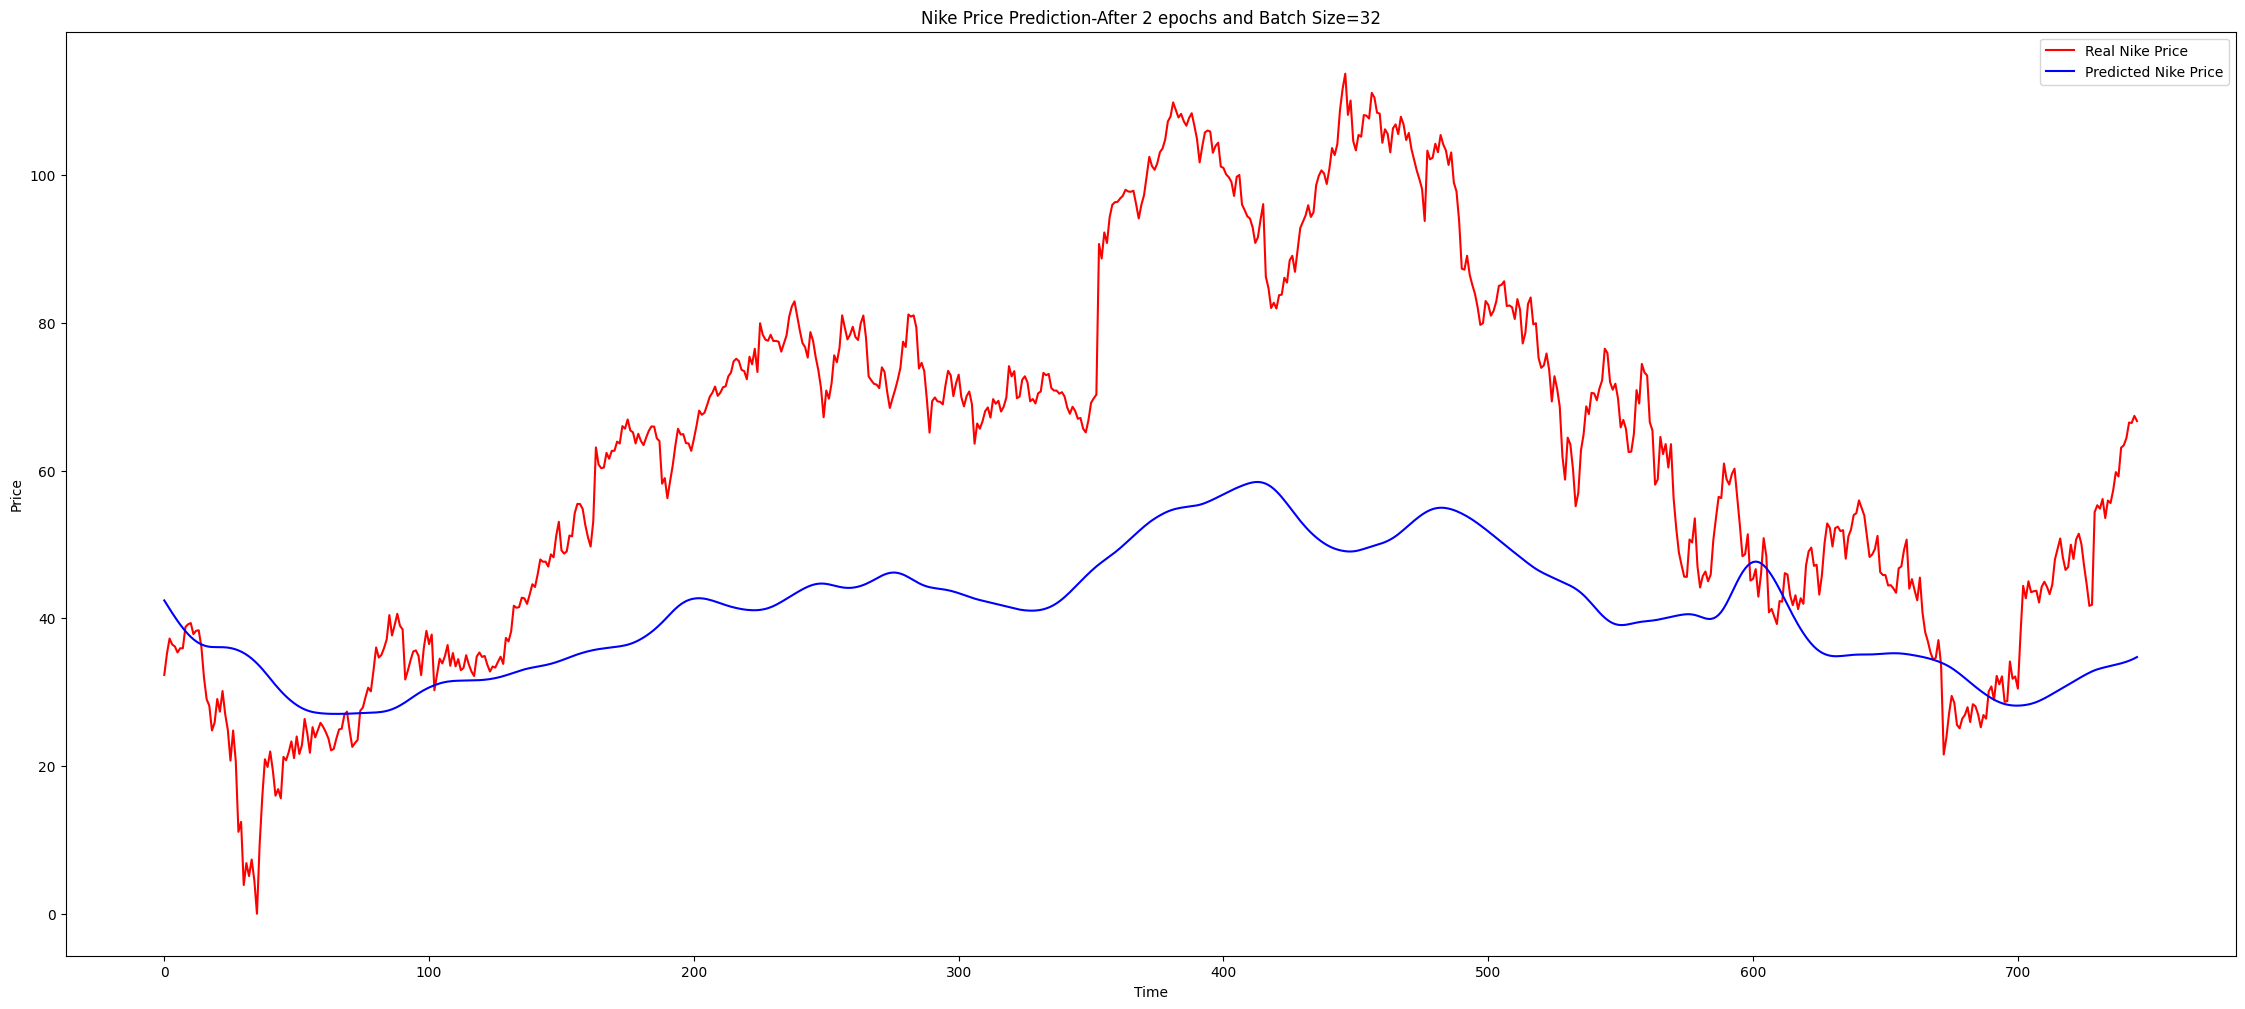

In [ ]:
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Nike Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Nike Price')
plt.title('Nike Price Prediction-After 2 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()